In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import utils
from tensorflow.python.client import device_lib
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Cropping2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Nadam
from matplotlib import pyplot as plt
%matplotlib inline
device_lib.list_local_devices()

WIDTH, HEIGHT = 124, 124
SOURCE_FILE = os.path.join('..', 'data', 'scull_set.txt.csv')

Using TensorFlow backend.


### Preprocessing

In [2]:
def preprocess_dataset(dataset):
    # Pop labels and transform them to vectors
    y = dataset.pop('label')
    y = y.values.reshape((-1, 1))
    # Reshape the features for CNN
    X = dataset.as_matrix().reshape(dataset.shape[0], 1, WIDTH, HEIGHT).astype(np.float32)
    # Norm data
    X /= 255
    # Convert labels to categorical values
    y = keras.utils.to_categorical(y, 2)
    return X, y

def get_shuffled_splitted_data(path=SOURCE_FILE):
    df = pd.read_csv(path)
    # Shuffle and split data into: 70% train, 20% test, 10% validation
    train, test, val = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])    
    # Extract labels, normalize, preprocess for keras
    X_train, y_train = preprocess_dataset(train)
    X_test, y_test = preprocess_dataset(test)
    X_val, y_val = preprocess_dataset(val)
    return X_train, y_train, X_test, y_test, X_val, y_val

# Collect new dataset containing sagittal images including scull and tumor
X_train, y_train, X_test, y_test, X_val, y_val = get_shuffled_splitted_data()

### Training the model (CNN)

In [3]:
def setup_model():
    model = Sequential()
    # model.add(Cropping2D(cropping=((0, 0), (62, 61)), input_shape=(1, WIDTH, HEIGHT)))
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(1, WIDTH, HEIGHT)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Removing the second Conv & MaxPooling layer ends up in 50% accuracy
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=categorical_crossentropy,
                  optimizer=Nadam(),
                  metrics=['accuracy'])
    return model

with tf.device('/gpu:0'):
    K.set_image_dim_ordering('th')
    batch_size = 32
    num_classes = 2
    epochs = 3
    # For storing the validation loss values
    history = keras.callbacks.History()
    # Train model
    model = setup_model()
    model_results = model.fit(X_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(X_test, y_test),
                              callbacks=[history])
    # Evaluate model on validation set
    print('\nValidate model on {} unknown validation samples:'.format(X_val.shape[0]))
    val_score = model.evaluate(X_val, y_val, verbose=0)
    print('Val loss:', val_score[0])
    print('Val accuracy:', val_score[1])

Train on 3098 samples, validate on 885 samples
Epoch 1/3
3098/3098 [==============================] - 31s - loss: 0.1578 - acc: 0.9493 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 2/3
3098/3098 [==============================] - 23s - loss: 0.0022 - acc: 0.9994 - val_loss: 3.2916e-04 - val_acc: 1.0000
Epoch 3/3
3098/3098 [==============================] - 24s - loss: 2.2756e-04 - acc: 1.0000 - val_loss: 1.2298e-04 - val_acc: 1.0000

Validate model on 443 unknown validation samples:
Val loss: 0.000134558685539
Val accuracy: 1.0


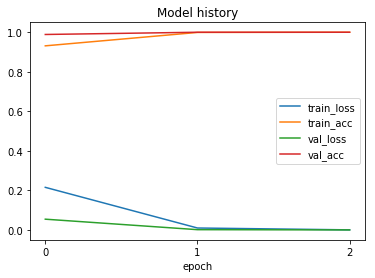

In [127]:
# Plot validation loss
utils.plot_history(model_results)

### Plotting results

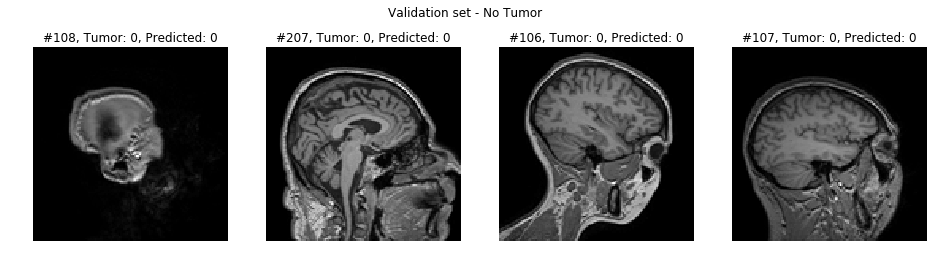

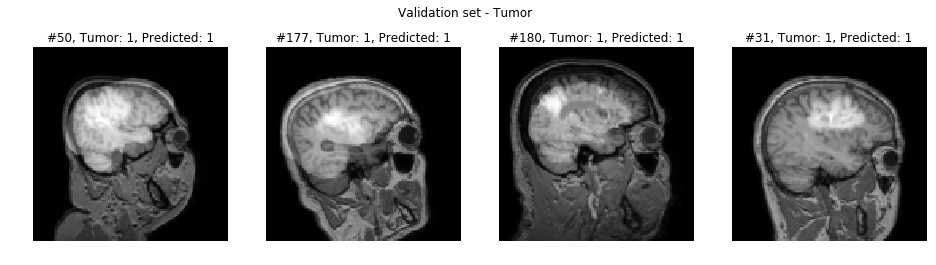

In [105]:
# Always same results
np.random.seed(1)
y_val_pred = model.predict(X_val, batch_size=32, verbose=0)
y_val_pred = np.round(y_val_pred).astype(int)
no_tumors = y_val.argmax(axis=1) == 0
utils.plot_predicted_samples(4, X_val[no_tumors], y_val[no_tumors], y_val_pred[no_tumors], 'Validation set - No Tumor')
utils.plot_predicted_samples(4, X_val[no_tumors == False], y_val[no_tumors == False], y_val_pred[no_tumors == False], 'Validation set - Tumor')

### Analysis

Our network converges unexpectedly quickly. This might be due to the following problems:
- The tumor images are resized and are somewhat blurred
- For some tumor images you can easily see that it has been created by two seperate pictures
- The healthy images contain sometimes a very different shape (e.g. above #108)

### Model structure 

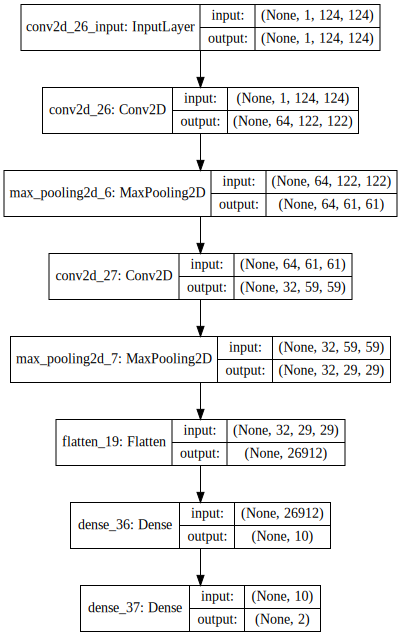

In [106]:
# Reload utils model if you changed a function
# import imp
# imp.reload(utils)
utils.plot_model(model, 'skull_classification_model.png')

In [108]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 64, 122, 122)      640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 61, 61)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 59, 59)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 29, 29)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 26912)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                269130    
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 22        
Total para